Read Data

In [219]:
import pandas as pd
import numpy as np

df = pd.read_csv("../file/input-mev.csv", index_col="Date", parse_dates=True)
target = df["delta_CPI_lag3Q"]

target = target.dropna()
nrows = len(target)-82
train = target.iloc[:-nrows]
test = target.iloc[-nrows:]

print("Shape of full data", target.shape)
print("Shape of train data", train.shape)
print("Shape of test data", test.shape)
df.head()

Shape of full data (121,)
Shape of train data (82,)
Shape of test data (39,)
2015-12-31 00:00:00


Plot the Data

In [216]:
import scipy.stats as stats

fitted_data, fitted_lambda = stats.boxcox(train)
print("Lambda : ", fitted_lambda)

ValueError: Data must be positive.

<Axes: xlabel='Date'>

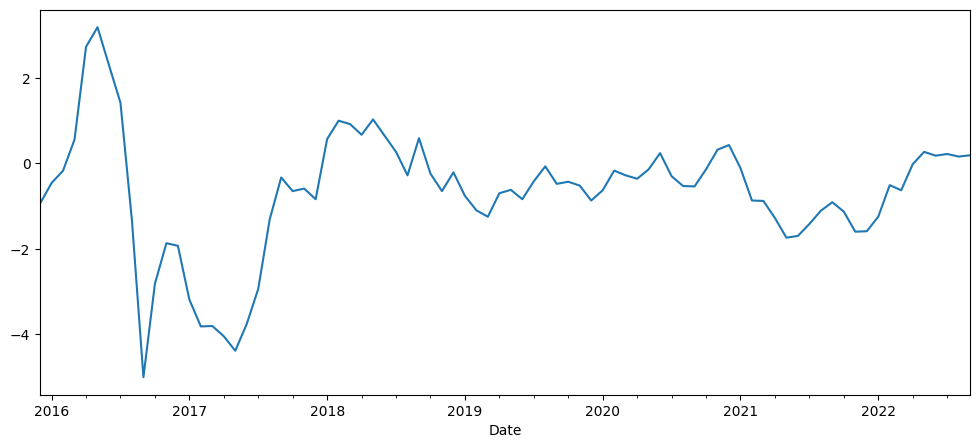

In [ ]:
train.plot(figsize=(12,5))

Dicky-Fuller Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag= "AIC")
    print("1. ADF :", dftest[0])
    print("2. P-value :", dftest[1])
    print("3. Num of Lags :", dftest[2])
    print("4. Num of Observations Used for ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical values :")

    for k, v in dftest[4].items():
        print("\t", k, ": ", v)

In [ ]:
ad_test(train)

1. ADF : -2.5757868414273664
2. P-value : 0.09810560592997564
3. Num of Lags : 12
4. Num of Observations Used for ADF Regression and Critical Values Calculation : 69
5. Critical values :
	 1% :  -3.528889992207215
	 5% :  -2.9044395987933362
	 10% :  -2.589655654274312


METHOD 1: USING AUTO_ARIMA from PMDARIMA and figure out Order for ARIMA models

In [ ]:
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [ ]:
stepwise_fit = auto_arima(train, trace=True, suppress_warnings=True, scoring="mse")
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=295.097, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=195.246, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=226.063, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=309.771, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=184.766, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=186.164, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=185.904, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=184.377, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=185.965, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=198.931, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=184.546, Time=0.02 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.459 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -88.189
Date:                Fri, 16 Jun 2023   AIC                            184.377
Time:                        16:53:21   BIC                            194.004
Sample:                    12-31-2015   HQIC                           188.242
                         - 09-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1746      0.138     -1.262      0.207      -0.446       0.097
ar.L1          0.7358      0.077      9.602      0.000       0.586       0.886
ma.L1          0.4380      0.105      4.163      0.000       0.232       0.644
sigma2         0.4937      0.050      9.820      0.000       0.395       0.592
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                89.29
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

METHOD 2: ITERATE THE ORDER

In [ ]:
import itertools
import statsmodels.api as sm

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 0) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

warnings.filterwarnings("ignore") # specify to ignore warning messages

RESULTS = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            result = ('ARIMA{} x {} 12 - AIC:{} - p-value:{}'.format(param, param_seasonal, results.aic, results.pvalues))
            RESULTS.append((result))
        except:
            continue
res = pd.DataFrame(RESULTS)
res.to_csv("../file/output_model_ARIMA.csv")

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 0)
SARIMAX: (0, 0, 1) x (0, 0, 2, 0)
SARIMAX: (0, 0, 2) x (0, 0, 3, 0)
SARIMAX: (0, 0, 2) x (0, 1, 0, 0)


Method 1: Train the model

In [ ]:
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.api.tsa.arima import ARIMA
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(train, order=stepwise_fit.order)
model = model.fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        delta_CPI_lag3Q   No. Observations:                   82
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -88.189
Date:                Fri, 16 Jun 2023   AIC                            184.377
Time:                        17:15:26   BIC                            194.004
Sample:                    12-31-2015   HQIC                           188.242
                         - 09-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6608      0.471     -1.403      0.161      -1.584       0.263
ar.L1          0.7358      0.077      9.602      0.000       0.586       0.886
ma.L1          0.4380      0.105      4.163      0.000       0.232       0.644
sigma2         0.4937      0.050      9.820      0.000       0.395       0.592
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                89.29
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Method 1 : Make predictions to Test Set

In [ ]:
start=len(train)

end=len(train)+len(test)-1

pred=model.predict(start=start, end=end, type="levels")

print(pred, start, end)

export = pd.DataFrame(pred)
export.to_csv("../file/output_result_forecast.csv")

2022-10-31    0.058539
2022-11-30   -0.131530
2022-12-30   -0.271379
2023-01-31   -0.374278
2023-02-28   -0.449989
2023-03-31   -0.505695
2023-04-28   -0.546683
2023-05-31   -0.576841
2023-06-30   -0.599031
2023-07-31   -0.615358
2023-08-31   -0.627371
2023-09-29   -0.636210
2023-10-31   -0.642714
2023-11-30   -0.647499
2023-12-29   -0.651020
2024-01-31   -0.653610
2024-02-29   -0.655516
2024-03-29   -0.656919
2024-04-30   -0.657951
2024-05-31   -0.658710
2024-06-28   -0.659269
2024-07-31   -0.659680
2024-08-30   -0.659982
2024-09-30   -0.660205
2024-10-31   -0.660368
2024-11-29   -0.660489
2024-12-31   -0.660577
2025-01-31   -0.660643
2025-02-28   -0.660691
2025-03-31   -0.660726
2025-04-30   -0.660752
2025-05-30   -0.660771
2025-06-30   -0.660785
2025-07-31   -0.660795
2025-08-29   -0.660803
2025-09-30   -0.660809
2025-10-31   -0.660813
2025-11-28   -0.660816
2025-12-31   -0.660818
Freq: BM, Name: predicted_mean, dtype: float64 82 120


Method 1 : Plot the predictions and actual values

<Axes: xlabel='Date'>

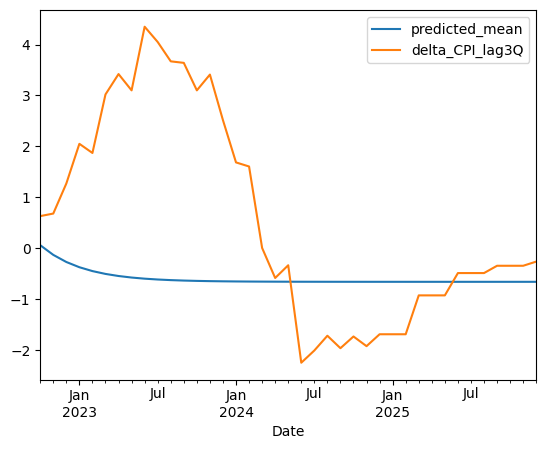

In [ ]:
pred.plot(legend=True)
test.plot(legend=True)

Method 1 : Grab mean values of tested predicted values

In [ ]:
test.mean()

0.5364724165384617

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

# rmse=sqrt(mean_squared_error(pred, test))
mape=mean_absolute_percentage_error(test, pred)
print(mape)


4.586506141393345


In [ ]:
model2=sm.tsa.arima.ARIMA(test, order=(1,1,0))
model2=model2.fit()
model2.summary()


pred=model2.predict(start=len(df), end=len(df)+8,type="levels").rename("ARIMA Predictions")

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        delta_CPI_lag3Q   No. Observations:                   39
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -35.005
Date:                Fri, 16 Jun 2023   AIC                             74.011
Time:                        17:19:23   BIC                             77.286
Sample:                    10-31-2022   HQIC                            75.176
                         - 12-31-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0033      0.223      0.015      0.988      -0.433       0.439
sigma2         0.3695      0.060      6.135      0.000       0.251       0.488
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.58
Prob(Q):                              0.99   Prob(JB):                         0.01
Heteroskedasticity (H):               0.18   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

For Future Dates

In [221]:
# index_future_dates=pd.date_range(start=train.index[-1], end=train.index[-1 + end])
# pred.index=index_future_dates

print(train.index[1])

2016-01-29 00:00:00


<Axes: >

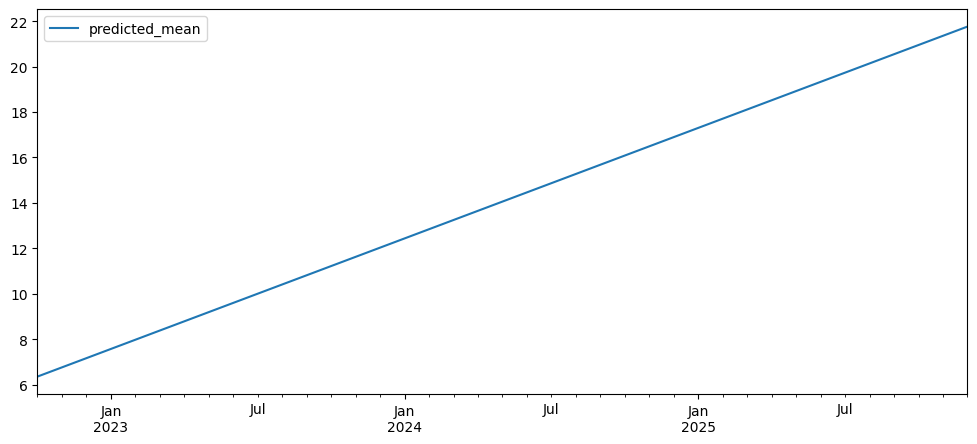

In [ ]:
pred.plot(figsize=(12,5),legend=True)